In [432]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

#from skbio.diversity import alpha_diversity
#from skbio.diversity import beta_diversity
#from skbio import TreeNode
from io import StringIO
#from skbio.stats.ordination import pcoa
from skbio.stats.composition import ancom
import math
from skbio.stats.composition import multiplicative_replacement
import numpy as np

In [60]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import tree

In [1]:
import cx_Oracle

SERVER = 'dboracle.itk.ppke.hu'
PORT = 1521
SERVICE = 'rsc.itk.ppke.hu'
USER = 'metagenome'
PASSWORD = 'LrJPRUS73r84'

class Connection():

    def __init__(self):
        dsn_tns = cx_Oracle.makedsn(SERVER, PORT, service_name=SERVICE)
        self.connection = cx_Oracle.connect(USER, PASSWORD, dsn_tns)

    def get_connection(self):
        return self.connection

    def select(self, sql):
        return pd.read_sql(sql, con=self.connection)

con = Connection()

# Dataset

In [10]:
class WrongRank(Exception):
    def __init__(self, value):
        self.value = value
    def __str__(self):
        return repr(self.value)

In [2]:
def get_table_and_grouping(df_name, table_files, column_to_group='STUDY_CONDITION', rank='F', 
                           use_percent= True, percent=30, group=None):

    for file in table_files:
        if df_name in file:
            index = table_files.index(file)
            
    df = get_data_for_sample(table_files[index])
    print(df.head())
    df_2 = df.loc[df['Rank'] == rank]
    
    if len(df_2) == 0:
        raise WrongRank(rank)
    
    df_2 = df_2[['Sample_ID', 'Name', 'Abundance', column_to_group]]
    df_2 = df_2.loc[[i == i for i in df_2[column_to_group]]]

    if group is not None:
        df_2[column_to_group] = [group if group in v else "Control" for v in df_2[column_to_group]]
                       
    table = df_2.pivot(index='Sample_ID', columns='Name', values='Abundance')
    
    # Dropping sparse columns
    if use_percent:
        counts = {}
        to_drop = []
        for column in table.columns:
            counts[column] = table[column].loc[table[column].notnull()].count() + table[column].loc[table[column] != 0].count()
            
            if counts[column] < table.shape[1]/100*percent:
                to_drop.append(column)
        table = table.drop(columns = to_drop)
    
    print("Shape of table:", table.shape)
    
    # Handling remaining Nan values and zero values
    table = table.fillna(0)
    table_repl = pd.DataFrame(multiplicative_replacement(table.values),
                      index=table.index,
                      columns=table.columns)

    grouping = df_2[['Sample_ID', column_to_group]].drop_duplicates()
    grouping.index = grouping["Sample_ID"]
    grouping = grouping.drop(columns = ["Sample_ID"])
    
    grouping_ser = grouping[column_to_group]

    return table_repl, grouping_ser

In [3]:
def get_data_for_sample(path_to_file):
    dataset = path_to_file.split('/')[-1]
    df = pd.read_csv(path_to_file, delimiter = ',')
    df['Dataset'] = dataset
    df["Name"] = [n.strip() for n in df["Name"]]
    return df

In [8]:
path_metaphlan = '//gfs/data/curated_metagenomes_metaphlan2/'

files_metaphlan = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path_metaphlan):
    for file in f:
        if '.csv' in file:
            files_metaphlan.append(os.path.join(path_metaphlan, file))
print(files_metaphlan)

['//gfs/data/curated_metagenomes_metaphlan2/AsnicarF_2017.csv', '//gfs/data/curated_metagenomes_metaphlan2/ChngKR_2016.csv', '//gfs/data/curated_metagenomes_metaphlan2/FengQ_2015.csv', '//gfs/data/curated_metagenomes_metaphlan2/VogtmannE_2016.csv', '//gfs/data/curated_metagenomes_metaphlan2/YuJ_2015.csv']


In [435]:
path_kraken = '//gfs/data/curated_metagenomes_kraken2/'

files_kraken = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path_kraken):
    for file in f:
        if '.csv' in file:
            files_kraken.append(os.path.join(path_kraken, file))
print(files_kraken)

['//gfs/data/curated_metagenomes_kraken2/RampelliS_2015.csv', '//gfs/data/curated_metagenomes_kraken2/AsnicarF_2017.csv', '//gfs/data/curated_metagenomes_kraken2/ChngKR_2016.csv', '//gfs/data/curated_metagenomes_kraken2/FengQ_2015.csv', '//gfs/data/curated_metagenomes_kraken2/Heitz-BuschartA_2016.csv', '//gfs/data/curated_metagenomes_kraken2/KarlssonFH_2013.csv', '//gfs/data/curated_metagenomes_kraken2/LeChatelierE_2013.csv', '//gfs/data/curated_metagenomes_kraken2/LiuW_2016.csv', '//gfs/data/curated_metagenomes_kraken2/LomanNJ_2013.csv', '//gfs/data/curated_metagenomes_kraken2/Obregon-TitoAJ_2015.csv', '//gfs/data/curated_metagenomes_kraken2/QinJ_2012.csv', '//gfs/data/curated_metagenomes_kraken2/QinN_2014.csv', '//gfs/data/curated_metagenomes_kraken2/SchirmerM_2016.csv', '//gfs/data/curated_metagenomes_kraken2/VatanenT_2016.csv', '//gfs/data/curated_metagenomes_kraken2/VogtmannE_2016.csv', '//gfs/data/curated_metagenomes_kraken2/XieH_2016.csv', '//gfs/data/curated_metagenomes_kraken2

In [14]:
path = "//gfs/data/curated_metagenomes_metaphlan2/VogtmannE_2016.csv"

table_repl, grouping_ser = get_table_and_grouping(path, files_metaphlan, rank = 'g')

   Unnamed: 0   Sample_ID             Dataset Rank             Name  \
0           0  ERR1293543  VogtmannE_2016.csv    k         Bacteria   
1           1  ERR1293543  VogtmannE_2016.csv    p       Firmicutes   
2           2  ERR1293543  VogtmannE_2016.csv    p    Bacteroidetes   
3           3  ERR1293543  VogtmannE_2016.csv    p   Actinobacteria   
4           4  ERR1293543  VogtmannE_2016.csv    p  Verrucomicrobia   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0  100.00000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1   60.42390             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2   34.15000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3    4.87067             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4    0.55544             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2  NaN        adult 

In [15]:
table_repl.head()

Name,Acidaminococcaceae_unclassified,Acidaminococcus,Actinomyces,Adlercreutzia,Akkermansia,Alistipes,Anaerococcus,Anaerofustis,Anaerostipes,Anaerotruncus,...,Ruminococcus,Siphoviridae_noname,Slackia,Solobacterium,Streptococcus,Subdoligranulum,Sutterella,Sutterellaceae_unclassified,Turicibacter,Veillonella
Sample_ID,,,,,,,,,,,,,,,,,,,,,
ERR1293497,0.000142,0.000142,0.000142,0.000664,0.007777,0.051931,0.000142,0.000142,0.013660,0.000404,...,0.083284,0.000142,0.000142,0.000142,0.002169,0.046098,0.000142,0.000142,0.000142,0.002977
ERR1293498,0.000142,0.000142,0.000142,0.000708,0.008262,0.055026,0.000142,0.000142,0.015261,0.000832,...,0.083028,0.000142,0.000142,0.000142,0.001866,0.043990,0.000142,0.000142,0.000142,0.003441
ERR1293499,0.000142,0.000142,0.000142,0.000614,0.008643,0.057695,0.000142,0.000142,0.014270,0.000142,...,0.088951,0.000142,0.000142,0.000142,0.002068,0.051729,0.000142,0.000142,0.000142,0.003225
ERR1293500,0.000142,0.000142,0.000142,0.000659,0.008028,0.054997,0.000142,0.000142,0.014251,0.000142,...,0.085211,0.000142,0.000142,0.000142,0.002094,0.042908,0.000142,0.000142,0.000142,0.002765
ERR1293501,0.000142,0.000142,0.000142,0.000142,0.000142,0.016568,0.000142,0.000142,0.001093,0.000259,...,0.021568,0.000142,0.000142,0.000142,0.000024,0.072611,0.000142,0.000142,0.000142,0.000142


In [16]:
grouping_ser.head()

Sample_ID
ERR1293589    control
ERR1293497    control
ERR1293566        CRC
ERR1293520        CRC
ERR1293590    control
Name: STUDY_CONDITION, dtype: object

In [17]:
grouping_ser.drop_duplicates()

Sample_ID
ERR1293589    control
ERR1293566        CRC
Name: STUDY_CONDITION, dtype: object

# SELBAL
Our algorithm for balance selection, selbal, starts with a first thorough search of the
two taxa whose balance, or log ratio, is most closely associated with the response. Once
the first two-taxon balance is selected, the algorithm performs a forward selection
process where, at each step, a new taxon is added to the existing balance such that the
specified criterion is improved (area under the receiver operating characteristic [ROC]
curve [AUC] or mean squared error [MSE]). The algorithm stops when there is no
additional variable that improves the current optimization parameter or when the
maximum number of components to be included in the balance is achieved. This
number is established with a cross-validation (CV) procedure, which is also used to
explore the robustness of the identified balance. A more detailed description of the
algorithm is given in Materials and Methods

1. thorough search of the two taxa whose balance, or log ratio, is most closely associated with the response
2. performs a forward selection process where, at each step, a new taxon is added to the existing balance such that the specified criterion is improved
3. The algorithm stops when there is no additional variable that improves the current optimization parameter or when the maximum number of components to be included in the balance is achieved

## Balance

In [31]:
def balance(X_i, X_j):
    if len(X_i) != len(X_j):
        raise("Columns' length not equal")
    k = len(X_i)
    B = math.sqrt(1/2)*(np.log(X_i) - np.log(X_j))
    return B

In [68]:
X_i = np.array([10,5,30,46,1,2])
X_j = np.array([1,2,12,45,201,40])
B = balance(X_i, X_j)
B

array([ 1.62817353,  0.64791539,  0.64791539,  0.01554143, -3.75000286,
       -2.11830261])

In [69]:
B.reshape(-1, 1)

array([[ 1.62817353],
       [ 0.64791539],
       [ 0.64791539],
       [ 0.01554143],
       [-3.75000286],
       [-2.11830261]])

## Logit

In [137]:
def get_AUC(data, target):
    x_train, x_test, y_train, y_test = train_test_split(data, 
            target, test_size=0.2, random_state=0)

    logisticRegr = LogisticRegression(solver= 'liblinear')
    logisticRegr.fit(x_train, y_train)

    #Konfidencia scoreok a teszt halmazhoz
    y_score = logisticRegr.decision_function(x_test)

    #ROC görbe számolása
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    return roc_auc

In [96]:
cols = table_repl.columns
X = np.array(table_repl[cols[0:2]])
B = balance(X[:,0], X[:,1])
              
Y = [1 if v == "CRC" else 0 for v in grouping_ser]

get_AUC(B.reshape(-1, 1),Y)

/gfs/progs/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5208810068649886

### Step 1: optimal balance between two components.

In [396]:
def opt_bal_for_two(table, target):
    Y = [1 if v == "CRC" else 0 for v in target]
    max_col1 = table.columns[0]
    max_col2 = table.columns[1]
    max_auc = 0
    for col1 in table.columns:
        for col2 in table.columns:
            X = np.array(table[[col1,col2]])
            B = balance(X[:,0], X[:,1])

            roc_auc = get_AUC(B.reshape(-1, 1),Y)
            if roc_auc > max_auc:
                max_auc = roc_auc
                max_col1 = col1
                max_col2 = col2
    return max_col1, max_col2, max_auc

In [369]:
max_col1, max_col2, max_auc = opt_bal_for_two(table_repl, grouping_ser)

In [370]:
max_auc

0.7093821510297482

In [371]:
max_col1

'Bacteroides'

In [372]:
max_col2

'Siphoviridae_noname'

### Step s: optimal balance—adding a new component.

In [376]:
def balance_for_sets(pos_set, neg_set):
    pos_k = pos_set.shape[1]
    neg_k = neg_set.shape[1]
    
    pos_bal = np.zeros((pos_set.shape[0]))
    for k in range(pos_k):
        pos_bal = np.add(pos_bal, np.log(pos_set[:,k]))
    pos_bal = pos_bal * 1/(pos_k)
    
    neg_bal = np.zeros((neg_set.shape[0]))
    for k in range(neg_k):
        neg_bal = neg_bal+np.log(neg_set[:,k])
    neg_bal = neg_bal * 1/(neg_k)
    
    B = pos_bal - neg_bal
    return B

In [374]:
def test_assoc(table, target, pos_set_col_names, neg_set_col_names):
    Y = [1 if v == "CRC" else 0 for v in target]
    pos_set = np.array(table[pos_set_col_names])
    neg_set = np.array(table[neg_set_col_names])
    
    B = balance_for_sets(pos_set, neg_set)

    roc_auc = get_AUC(B.reshape(-1, 1),Y)
    return roc_auc

In [375]:
pos_set_col_names = ['Bacteroides','Acidaminococcus']
neg_set_col_names = ['Siphoviridae_noname']
table = table_repl
target = grouping_ser

test_assoc(table, target, pos_set_col_names, neg_set_col_names)

0.6716247139588101

In [316]:
np.log(pos_set[:,k]).shape

(417,)

In [318]:
pos_bal = np.zeros((pos_set.shape[0]))

In [319]:
pos_bal.shape

(417,)

In [320]:
np.add(pos_bal, np.log(pos_set[:,k])).shape

(417,)

In [362]:
def adding_new_comp(table, target, pos_set_names, neg_set_names, max_auc):
    
    columns = [col for col in table.columns if col not in pos_set_names 
               and col not in neg_set_names]
    max_auc_pos = max_auc
    max_auc_neg = max_auc
    which = None

    for col in columns:
        
        tmp_pos_set = []
        tmp_pos_set.extend(pos_set_names)
        tmp_pos_set.append(col)
        pos_auc = test_assoc(table, target, tmp_pos_set, neg_set_names)
        
        tmp_neg_set = []
        tmp_neg_set.extend(neg_set_names)
        tmp_neg_set.append(col)
        neg_auc = test_assoc(table, target, pos_set_names, tmp_neg_set)

        if pos_auc > neg_auc:
            if pos_auc > max_auc_pos:
                max_auc_pos = pos_auc
                pos_col = col
                which = "POS"
        else:
            if neg_auc > max_auc_neg:
                max_auc_neg = neg_auc
                neg_col = col
                which = "NEG"
    
    if which == "POS":
        pos_set_names.append(pos_col)
        max_auc = max_auc_pos
    elif which == "NEG":
        neg_set_names.append(neg_col)
        max_auc = max_auc_neg
        
    return pos_set_names, neg_set_names, max_auc
    

In [420]:
def opt_bal(table, target, threshold = 0, max_comp = 20):
    print("Optimal balance for 2 ...")
    max_col1, max_col2, max_auc = opt_bal_for_two(table, target)
    
    pos_set_names = [max_col1]
    neg_set_names = [max_col2]
    
    auc_list = [max_auc]
    
    comp_size = len(pos_set_names) + len(neg_set_names)
    
    crit = True
    while(crit):
        print("Choosing feature", comp_size+1)
        tmp_pos, tmp_neg, tmp_auc = adding_new_comp(table,
            target, pos_set_names, neg_set_names, max_auc)
        auc_groth = tmp_auc-max_auc
        print("new auc", tmp_auc)
        if auc_groth > threshold:
            pos_set_names = tmp_pos
            neg_set_names = tmp_neg
            auc_list.append(tmp_auc)
            max_auc = tmp_auc
            comp_size = comp_size + 1
            crit = max_comp > comp_size
        else:
            crit = False
    return pos_set_names, neg_set_names, max_auc, auc_list
        

In [421]:
pos_set_names, neg_set_names, max_auc, auc_list = opt_bal(table_repl, 
    grouping_ser, threshold = 0, max_comp = 20)

Optimal balance for 2 ...
Choosing feature 3
new auc 0.7820366132723112
Choosing feature 4
new auc 0.7957665903890161
Choosing feature 5
new auc 0.8054919908466819
Choosing feature 6
new auc 0.8329519450800915
Choosing feature 7
new auc 0.8524027459954233
Choosing feature 8
new auc 0.8535469107551488
Choosing feature 9
new auc 0.8546910755148742
Choosing feature 10
new auc 0.8598398169336385
Choosing feature 11
new auc 0.8827231121281465
Choosing feature 12
new auc 0.8878718535469108
Choosing feature 13
new auc 0.8941647597254004
Choosing feature 14
new auc 0.8987414187643019
Choosing feature 15
new auc 0.9067505720823797
Choosing feature 16
new auc 0.9113272311212814
Choosing feature 17
new auc 0.9147597254004577
Choosing feature 18
new auc 0.9164759725400458
Choosing feature 19
new auc 0.919908466819222
Choosing feature 20
new auc 0.9221967963386728


In [408]:
len(pos_set_names)

2

In [409]:
len(neg_set_names)

1

In [410]:
pos_set_names

['Bacteroides', 'Sutterellaceae_unclassified']

In [411]:
neg_set_names

['Siphoviridae_noname']

In [412]:
auc_list

[0.7093821510297482, 0.7820366132723112]

### Iterative cross validation

1. to identify the optimal number of components to be included in the balance
2. to explore the robustness of the global balance identified with the whole data set

- M be the number of iterations (default M = 10)
- K the number of folds in the cross-validation (default K = 5)
- C the maximum number of variables or components included in a balance (default C = 20)

At each iteration of m = {1, . . ., M}, the data are divided into K folds, D(1,m), . . ., D(K,m)

In [380]:
from sklearn.model_selection import KFold # import KFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]]) # create an array
y = np.array([1, 2, 3, 4]) # Create another array
kf = KFold(n_splits=2) # Define the split - into 2 folds 
kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
print(kf) 
KFold(n_splits=2, random_state=None, shuffle=False)

KFold(n_splits=2, random_state=None, shuffle=False)


KFold(n_splits=2, random_state=None, shuffle=False)

In [381]:
kf.split(X)

<generator object _BaseKFold.split at 0x7f917006b308>

In [384]:
for train_index, test_index in kf.split(X):
 print("TRAIN:", train_index, "TEST:", test_index)
 X_train, X_test = X[train_index], X[test_index]
 y_train, y_test = y[train_index], y[test_index]

TRAIN: [2 3] TEST: [0 1]
TRAIN: [0 1] TEST: [2 3]


### Training
1. split data to train and test
2. cross-validation for model selection (since now)
    1. folded data =  train + validation
    2. get model for each fold
    3. test each model on the appropriate validation data -> select model
3. train on whole train data with the selected model
4. test the selected, trained model on test data

What is our model?
1. Number of features to choose?
2. Chosen features?

#### MUST DO: split test data, before model selection and test on it in the end!

# TESTING

In [392]:
#table_repl, grouping_ser

In [389]:
len(list(table_repl.index))

417

In [390]:
X_train, X_test, y_train, y_test = train_test_split(table_repl, 
     grouping_ser, test_size=0.2)

In [422]:
pos_set_names, neg_set_names, max_auc, auc_list = opt_bal(X_train, 
    y_train, threshold = 0, max_comp = 20)

Optimal balance for 2 ...
Choosing feature 3
new auc 0.7642857142857142
Choosing feature 4
new auc 0.7839285714285715
Choosing feature 5
new auc 0.7848214285714284
Choosing feature 6
new auc 0.8205357142857144
Choosing feature 7
new auc 0.8263392857142857
Choosing feature 8
new auc 0.8361607142857143
Choosing feature 9
new auc 0.8433035714285714
Choosing feature 10
new auc 0.846875
Choosing feature 11
new auc 0.846875


In [423]:
auc_list

[0.7522321428571429,
 0.7642857142857142,
 0.7839285714285715,
 0.7848214285714284,
 0.8205357142857144,
 0.8263392857142857,
 0.8361607142857143,
 0.8433035714285714,
 0.846875]

In [440]:
def test_model(x_train, x_test, y_train, y_test, pos_set_names, neg_set_names):
    
    Y = [1 if v == "CRC" else 0 for v in y_train]
    pos_set = np.array(x_train[pos_set_names])
    neg_set = np.array(x_train[neg_set_names])
    
    B = balance_for_sets(pos_set, neg_set)

    x_train_2 = B.reshape(-1, 1)
    y_train_2 = Y
    
    logisticRegr = LogisticRegression(solver= 'liblinear')
    logisticRegr.fit(x_train_2, y_train_2)
    
    Y_test = [1 if v == "CRC" else 0 for v in y_test]
    pos_set_test = np.array(x_test[pos_set_names])
    neg_set_test = np.array(x_test[neg_set_names])
    
    B_test = balance_for_sets(pos_set_test, neg_set_test)
    
    x_test_2 = B_test.reshape(-1, 1)
    y_test_2 = Y_test

    #Konfidencia scoreok a teszt halmazhoz
    y_score = logisticRegr.decision_function(x_test_2)

    #ROC görbe számolása
    fpr, tpr, _ = roc_curve(y_test_2, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title( 'ROC curve')
    plt.legend(loc="lower right")

    return roc_auc

0.5501985252410664

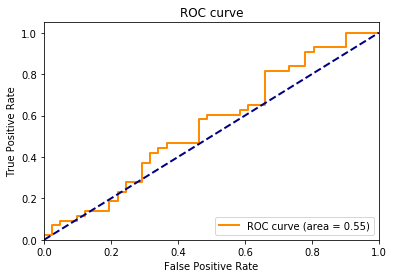

In [441]:
test_model(X_train, X_test, y_train, y_test, pos_set_names, neg_set_names)

In [450]:
def run_whole(dataset_name, method, rank, threshold = 0):
    
    # Find path to dataset file
    if method == "Kraken":
        table_files = files_kraken
        rank = rank.upper()
    else:
        if method == "Metaphlan":
            table_files = files_metaphlan
            rank = rank.lower()
        else:
            print("Wrong method! Method should be 'Kraken' or 'Metaphlan'")
            raise
    
    
    # Get data
    table_repl, grouping_ser = get_table_and_grouping(dataset_name, table_files, rank = rank)
    
    # Split to train and test data
    X_train, X_test, y_train, y_test = train_test_split(table_repl, 
     grouping_ser, test_size=0.2)
    
    # Model selection on train data
    pos_set_names, neg_set_names, max_auc, auc_list = opt_bal(X_train, 
    y_train, threshold = threshold, max_comp = 20)
    
    # Training on training data with selected model, than test it on test data
    test_model(X_train, X_test, y_train, y_test, pos_set_names, neg_set_names)

   Unnamed: 0   Sample_ID             Dataset Rank             Name  \
0           0  ERR1293543  VogtmannE_2016.csv    k         Bacteria   
1           1  ERR1293543  VogtmannE_2016.csv    p       Firmicutes   
2           2  ERR1293543  VogtmannE_2016.csv    p    Bacteroidetes   
3           3  ERR1293543  VogtmannE_2016.csv    p   Actinobacteria   
4           4  ERR1293543  VogtmannE_2016.csv    p  Verrucomicrobia   

   Abundance STUDY_CONDITION BODY_SITE              SUBJECTID COUNTRY DISEASE  \
0  100.00000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
1   60.42390             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
2   34.15000             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
3    4.87067             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   
4    0.55544             NaN     stool  MMRS92727331ST-27-0-0     USA     NaN   

   AGE AGE_CATEGORY  
0  NaN        adult  
1  NaN        adult  
2  NaN        adult 

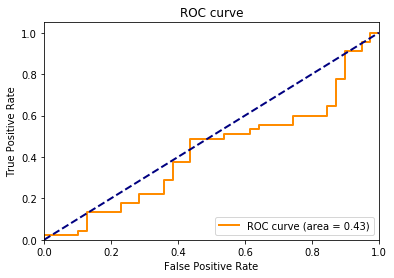

In [452]:
run_whole("VogtmannE_2016", "Metaphlan", "s", threshold = 0.02)

#### NAGYON rátanul az adathalmazra

Rosszul választjuk a modelt? A model ellenőrzésénél mindig véletlenszerű a teszt halmaz, így minden adatot felhasználunk a model kiválasztásnál, az AUC értékek így nem relevánsak! Legyen mindig ugyan az a teszt! 